<a target="_blank"  href="https://www.birmingham.ac.uk/schools/chemical-engineering/index.aspx"><img src="https://intranet.birmingham.ac.uk/staff/images/brand/download/jpg/crested-wm-full-colour.jpg" style="height:200px; display: block; margin-left: auto; margin-right: auto;"/></a>


# **Interactive Example:** Using a GranuTools GranuDrum Digital Twin
#### Setting up, running and post-processing a LIGGGHTS simulation and comparing it to experimental measurements

---

#### Copyright 2023 The Coexist Developers.
##### Notebook authored by Andrei Leonard Nicusan.

Licensed under the GNU License, Version 3.0.






## **What**: a DEM digital twin of an Angle of Repose tester

The GranuTools GranuDrum is a widely-used bulk powder characterisation device for measuring the dynamic angle of repose of a material. The shape of the powder *free surface* forming in the rolling regime of a rotating drum is very sensitive to the frictional and cohesive properties of granular materials (and, if post-processed correctly, even to their restitution to an extent) - and so can also be used to calibrate the microscopic properties of a discrete element method particle simulation.

This tutorial introduces a **DEM digital twin of a GranuTools GranuDrum using LIGGGHTS**, a popular, open-source DEM engine.

![GranuDrum Digital Twin](https://coexist.readthedocs.io/en/latest/_images/cost_function.png)

## **How**: Pre-Requisites

#### To run DEM simulations
The most significant pre-requisite of this notebook is LIGGGHTS itself, though you will be able to run the post-processing code without it using the included example data. As DEM is (very) compute-intensive, the core engines are typically written in lower-level programming languages like C++ - which are, however, more difficult to compile and run. You can install LIGGGHTS from a number of repositories - instructions included:

- https://github.com/uob-positron-imaging-centre/PICI-LIGGGHTS : the Birmingham fork of LIGGGHTS, including a number of fixes for modern C++ compilers and recent VTK versions.
- https://github.com/CFDEMproject/LIGGGHTS-PUBLIC : the original LIGGGHTS repository.

#### To run post-processing code
The post-processing code is written in Python, so its dependencies can be conveniently installed by running the next code cell:

In [ ]:
# Install Python libraries (LIGGGHTS should be installed separately)
!pip install konigcell opencv-python pyvista

## Running the Digital Twin

Once you have LIGGGHTS installed on your system, you can run the digital twin using (example commands, not interactive):
```shell
liggghts -in granudrum.sim
```

Or running it on multiple CPUs with:
```shell
mpiexec -np 4 liggghts -in granudrum.sim
```

That's it!

If you do have `liggghts` on your system - or on the online JupyterHub / BinderHub runtime you may be on - we can run a coarse-grained simulation (particle sizes are doubled, so it takes about 2 minutes to complete) with:

In [2]:
%%bash
liggghts -in granudrum_coarse.sim

LIGGGHTS (Version LIGGGHTS-PUBLIC 3.8.0, compiled 2023-06-09-18:46:11 by anicusan, git commit 8a33b0336f722b8e43165e20f27c097dde84c14d)
Created orthogonal box = (-0.043 -0.001 -0.043) to (0.043 0.021 0.043)
  1 by 1 by 1 MPI processor grid
	The contact model you specified is not located in any whitelist.
	Because of this the model will be run in an unoptimized version (increasing runtime by up to 20%).
	In order to optimize this model you have the following options:
		(i)  Run the genAutoExamplesWhitelist.sh script in your LIGGGHTS(R) source folder to automatically parse the input script
		(ii) Add the model combination by hand to your style_contact_model_user.whitelist that can be found in your LIGGGHTS(R) source folder
	If you perform one of the steps above LIGGGHTS(R) needs to be recompiled to generate the optimized code.

 (/Users/anicusan/Prog/LIGGGHTS/PICI-LIGGGHTS/src/contact_models.h:364)

Reading STL file 'mesh/rotating_drum.stl' (mesh processing step 1/3) 

Reading STL file '

### But what is it actually doing?

That's much more important - we can inspect the commented `granudrum.sim` script, which is written in a domain-specific language from LAMMPS; you can open it by double-clicking in the left panel.

The most important sections are at the top, for example:

```julia
# Simulation control
variable Timestep       equal 1e-5                  # Integrator timestepping
variable DumpTime       equal 0.01                  # Saving VTK interval
variable SetupTime      equal 1                     # Seconds before saving results
variable RunTime        equal 1                     # Seconds of run time after setup

variable RotationPeriod equal 60/45                 # s per revolution
variable NumParticles   equal 29954                 # Number of particles
variable ParticleRate   equal ${NumParticles}*10    # Particle insertion rate
```

The variable names and comments are self-explanatory: in this case we are running the GranuDrum at 45 RPM (the `variable RotationPeriod equal 60/45` line) using $29,954$ particles (the number of particles in a 50 mL "beaker" simulation). We run it initially for 1 second to reach steady-state (the `variable SetupTime      equal 1`) and then for another second while saving results at 100 FPS.

You can change the particle properties in the next section:

```julia
# Particle-particle (PP) and particle-wall (PW) interaction constants
variable Density        equal 1580
variable YoungsModulus  equal 5e6
variable PoissonRatio   equal 0.3

variable SlidingPP      equal 0.6       # ACCES-calibrated value 0.5613
variable SlidingPW      equal 0.6       # Anonymous company value 0.6

variable RollingPP      equal 0.5       # ACCES-calibrated value 0.2931
variable RollingPW      equal 0.5       # Anonymous company value 0.5

variable RestitutionPP  equal 0.3
variable RestitutionPW  equal 0.3

variable CohesionPP     equal 0  
variable CohesionPW     equal 0  
```

All GranuDrum geometry is included in the `mesh` folder as STL files.


### And results?

Once the simulation has been run, the `post` folder will contain the instantaneous particle data (positions, velocities, forces, etc.) saved at each requested timestep, e.g. `post/particles_72000.vtk`. The VTK format (for the "Visualization Toolkit") is popular for scientific data; it is commonly visualised using the open-source [ParaView](https://www.paraview.org/) graphical program - it is very powerful, and can produce beautiful figures of our [various digital twins](https://github.com/uob-positron-imaging-centre/DigitalTwins):

![DEM ParaView Renders](https://github.com/uob-positron-imaging-centre/ACCES-GranuDrum-Calibration/blob/main/Images/DEM-ParaView.png?raw=true)

---
Alternatively, we can open the VTK results directly in Python and run our own post-processing code.

## Post-Processing and Comparison to Measurements

The documented Python script `postprocess.py` contains all the code to:

- Load and process an experimental image of the GranuDrum at 45 RPM (see the `Measurements` folder).
- Load the DEM data and create a high-fidelity rasterized side-view of the simulated particles in the GranuDrum.
- Superimpose the two and compute an error between the two surfaces.
- Plot the above.

We can run it in the code cell below:

Error to experiment = 234.57788347205715 mm2


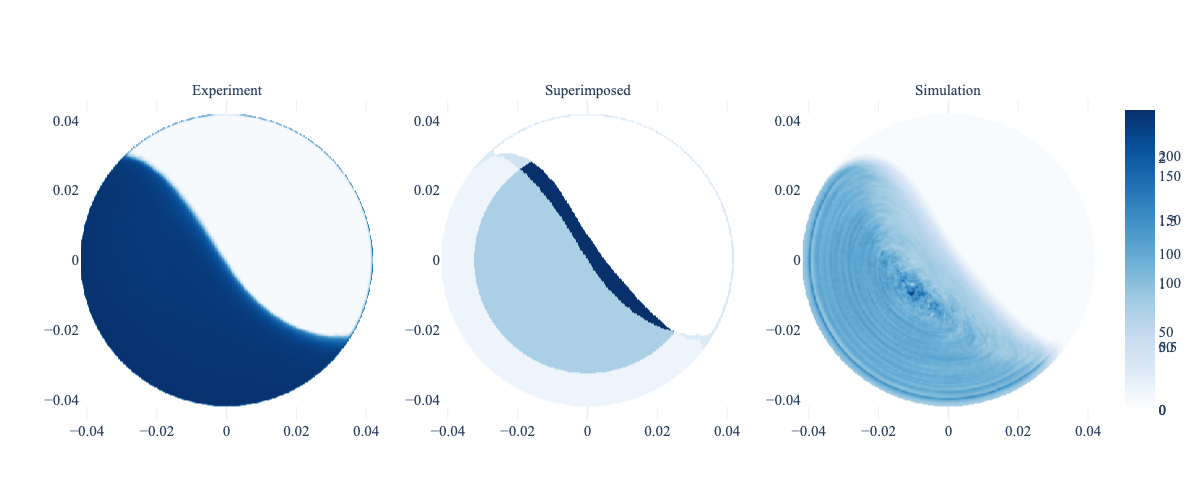

In [3]:
# Set plots' renderer - e.g. "iframe", "browser", "pdf", "png"
import plotly
plotly.io.renderers.default = "png"

%run postprocess.py

---
Now we could try to tweak the DEM contact parameters (`SlidingPP/PW`, `RollingPP/PW`, `CohesionPP/PW`) to calibrate the simulation - in essence back-computing the microscopic powder properties from a bulk measurement.

Or we could let ACCES autonomously calibrate and characterise the particles for us using the DEM digital twin - see the next tutorial for this.